In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.15.0'

In [3]:
# Load training and eval data from tf.keras
(train_data,train_labels),(test_data,test_labels)=\
tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(train_data.shape,train_labels.shape)

(60000, 28, 28) (60000,)


In [5]:
train_data,valid_data,train_labels,valid_labels=\
train_test_split(train_data,train_labels,test_size=0.1,shuffle=True)#분할, 따로 저장

In [6]:
print(train_data.shape, train_labels.shape)

(54000, 28, 28) (54000,)


In [7]:
print(valid_data.shape, valid_labels.shape)

(6000, 28, 28) (6000,)


label = 2


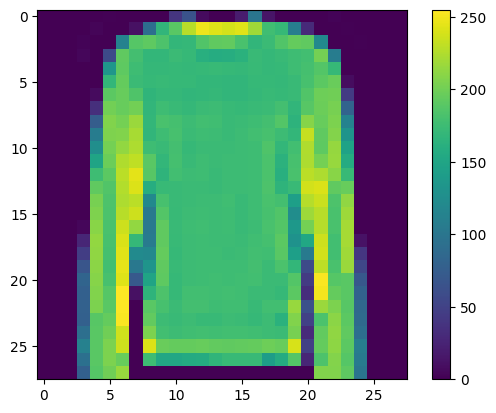

In [8]:
index=5901
print("label = {}".format(valid_labels[index]))
plt.imshow(valid_data[index].reshape(28,28))
plt.colorbar()
plt.show()

In [9]:
train_data=train_data/255. # rgb는 255까지의 값을 가지므로 0,1로 스케일링
train_data=train_data.reshape(-1,28*28)# 이미지 크기 변경
train_data=train_data.astype(np.float32) #이미지 형태 변경
train_labels=train_labels.astype(np.int32) #정수 레이블 사용

test_data=test_data/255. # rgb는 255까지의 값을 가지므로 0,1로 스케일링
test_data=test_data.reshape(-1,28*28)# 이미지 크기 변경
test_data=test_data.astype(np.float32) #이미지 형태 변경
test_labels=test_labels.astype(np.int32) #정수 레이블 사용


valid_data=valid_data/255. # rgb는 255까지의 값을 가지므로 0,1로 스케일링
valid_data=valid_data.reshape(-1,28*28)# 이미지 크기 변경
valid_data=valid_data.astype(np.float32) #이미지 형태 변경
valid_labels=valid_labels.astype(np.int32) #정수 레이블 사용

print(train_data.shape,train_labels.shape)#각 데이터 값 크기 출력
print(test_data.shape,test_labels.shape)
print(valid_data.shape,valid_labels.shape)

(54000, 784) (54000,)
(10000, 784) (10000,)
(6000, 784) (6000,)


In [10]:
def one_hot_label(image,label): #one hot으로 변경, 조건과 같으면 1, 아니면 0
  label=tf.one_hot(label,depth=10)
  return image, label

batch_size=32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# for test
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [11]:
"""def __init__(self,
             units,
             activation=None,
             use_bias=True,
             kernel_initializer='glorot_uniform',
             bias_initializer='zeros',
             kernel_regularizer=None,
             bias_regularizer=None,
             activity_regularizer=None,
             kernel_constraint=None,
             bias_constraint=None,
             **kwargs):
"""

model=tf.keras.Sequential([
      layers.Dense(64,activation='relu'),
      layers.Dense(32,activation='relu'),
      layers.Dense(16,activation='relu'),
      layers.Dense(10),
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])





In [12]:
# 사전 학습값을 가지고 실행
predictions=model(train_data[0:1],training=False)
print("Predictions: ", predictions.numpy())



Predictions:  [[-0.02969044  0.01751106  0.03276137  0.04580041 -0.01408854 -0.03563877
   0.03836237 -0.04244357  0.0199371   0.03181991]]


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 64)                   50240     
                                                                 
 dense_1 (Dense)             (1, 32)                   2080      
                                                                 
 dense_2 (Dense)             (1, 16)                   528       
                                                                 
 dense_3 (Dense)             (1, 10)                   170       
                                                                 
Total params: 53018 (207.10 KB)
Trainable params: 53018 (207.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
check_point_cb = callbacks.ModelCheckpoint('fashion_mnist_model.h5', #이벤트 발생 시 저장, 널아간 데이터 중간저장
                                           save_best_only=True,
                                           verbose=1)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True,
                                            verbose=1)

In [17]:
max_epochs = 100
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_data) // batch_size,
                    validation_data=valid_dataset,
                    validation_steps=len(valid_data) // batch_size,
                    callbacks=[check_point_cb, early_stopping_cb]
                   )

Epoch 1/100
1680/1687 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.9046
Epoch 1: val_loss did not improve from 0.32847
1687/1687 [==============================] - 7s 4ms/step - loss: 0.2643 - accuracy: 0.9047 - val_loss: 0.3361 - val_accuracy: 0.8790
Epoch 2/100
1679/1687 [============================>.] - ETA: 0s - loss: 0.2620 - accuracy: 0.9057
Epoch 2: val_loss did not improve from 0.32847
1687/1687 [==============================] - 8s 5ms/step - loss: 0.2621 - accuracy: 0.9056 - val_loss: 0.3381 - val_accuracy: 0.8780
Epoch 3/100
1682/1687 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.9070
Epoch 3: val_loss improved from 0.32847 to 0.32729, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 8s 5ms/step - loss: 0.2595 - accuracy: 0.9070 - val_loss: 0.3273 - val_accuracy: 0.8820
Epoch 4/100
1682/1687 [============================>.] - ETA: 0s - loss: 0.2576 - accuracy: 0.9079
Epoch 4: val_loss di

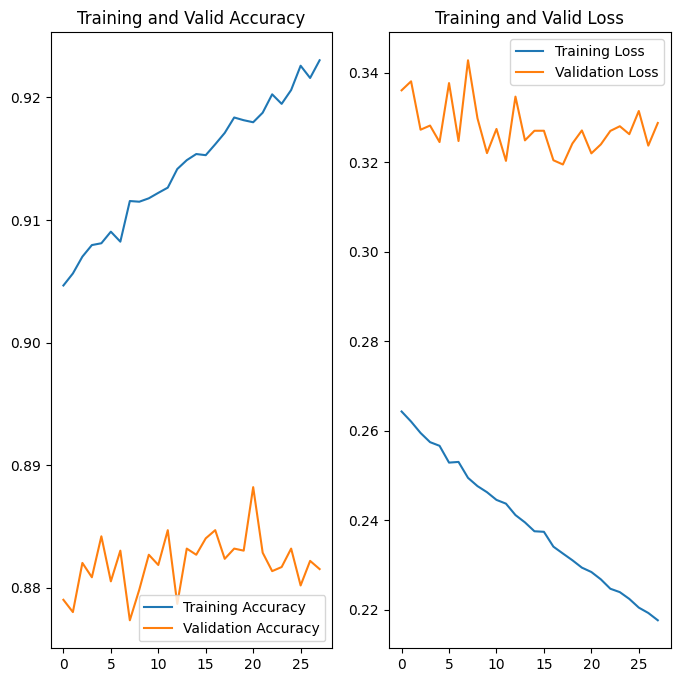

In [18]:
acc = history.history['accuracy'] #중간에 한번 정지시켰다가 다시 시작해서 history기록이 중간부터 적용되었습니다
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [19]:
results = model.evaluate(test_dataset)

313/313 [==============================] - 1s 2ms/step - loss: 0.3541 - accuracy: 0.8797
